### wls_estimator.ipynb
- Siep Dokter
- Emil Jousimaa
- Oleksandr Sosovskyy
- Mario Gabriele Carofano

> This file contains the implementation of the WLS estimator, used for estimate the Target Coordinates starting from the RSS information coming from the anchors.

In [1]:
# IMPORTS
import import_ipynb
import constants
import auxfunc
import pandas as pd
import numpy as np
import pprint
import math
import matplotlib.pyplot as plot

importing Jupyter notebook from constants.ipynb
importing Jupyter notebook from auxfunc.ipynb


In [2]:
def calculate_target_anchors_distance(anchor_dataframe):
    """
    Calculates the distance between the target and the anchors using the Euclidean norm.
    This is the implementation of (1) on the reference paper.

    Parameters:
    anchor_dataframe (DataFrame): A DataFrame-object containing the dataset of one anchor.

    Returns:
    target_anchors_distance (list): Returns a list of distances between the target and the anchor.
    """

    anchor_coords = [eval(i) for i in anchor_dataframe["Relative Coordinates [m]"][0].split(", ")]
    target_coords = [eval(i) for i in anchor_dataframe["Target Coordinates [m]"][0].split(", ")]
    target_anchors_distance = math.dist(anchor_coords, target_coords)

    return target_anchors_distance

# https://www.w3schools.com/python/ref_math_dist.asp
# https://www.w3schools.com/python/ref_string_split.asp
# https://www.geeksforgeeks.org/python-converting-all-strings-in-list-to-integers/

In [3]:
def calculate_target_anchors_estimation(average_RSS):
    """
    Calculates the distance estimates between each anchor and the target.
    This is the implementation of (4) on the reference paper.

    Parameters:
    average_RSS (list): A list which values are the average_RSS over a burst of 'constants.BURST_SIZE' consecutive measurements.

    Returns:
    estimated_distances (list): Returns a list which values are the distance estimations.
    """
    
    estimated_distances = []
    index = 0
    
    for mean in average_RSS:
        num = mean - constants.REFERENCE_POWER
        den = -10 * constants.PATH_LOSS_EXPONENT
        estimated_distances.append(round(10**(num/den), 3))
        index = index + 1

    return estimated_distances

In [4]:
def calculate_A_matrix(n_anchors, local_anchor_coords):

    # Build matrix A
    A = np.zeros((n_anchors, 3))  # 3 columns for -2x, -2y, 1

    for i in range(n_anchors):
        A[i, 0] = -2 * local_anchor_coords[i][0]
        A[i, 1] = -2 * local_anchor_coords[i][1]
        A[i, 2] = 1

    return A

In [5]:
def calculate_b_vector(n_anchors, local_anchor_coords, local_estimated_distances):
    """
    Calculates the 'b' vector of the system of equations which the WLS method solves.
    This is the implementation of (5) on the reference paper.

    Parameters:
    n_anchors (int): An integer which value represents the number of anchors in dataset.
    local_anchor_coords (list) : A list containing one list for each anchor, e.g. the 2D-coordinates of each anchor.
    local_estimated_distances (list) : A list containing one real number for each anchor, e.g. the distance estimation between each anchor and the target.

    Returns:
    b (numpy.ndarray): Returns a 1D numpy.ndarray which values are elements of the 'b' vector for the selected configuration.
    """
    
    norm_coords = []
    b = []

    for i in range(n_anchors):
        sqr_distance = math.pow(local_estimated_distances[i], 2)
        norm_coords.append(np.linalg.norm(local_anchor_coords))
        sqr_coords = math.pow(norm_coords[i], 2)
        diff = sqr_distance - sqr_coords
        b.append(round(diff, 3))
        i = i + 1
    
    return np.array(b)

# https://www.digitalocean.com/community/tutorials/norm-of-vector-python
# https://numpy.org/doc/stable/reference/generated/numpy.append.html

In [6]:
def calculate_W_matrix(n_anchors, local_estimated_distances):
    """
    Calculates, for the selected configuration, the 'W' diagonal matrix.
    The elements are the inverse of the variance of the square of the estimated distance.
    This is the implementation of [11, eq. (14)].

    Parameters:
    n_anchors (int): An integer which value represents the number of anchors in dataset.
    local_estimated_distances (list) : A list containing one real number for each anchor, e.g. the distance estimation between each anchor and the target.

    Returns:
    W (numpy.ndarray): Returns a 2D numpy.ndarray which values are elements of the 'W' diagonal matrix for the selected configuration.
    """

    num = math.pow(constants.STANDARD_DEVIATION, 2)
    den = 4.715 * math.pow(constants.PATH_LOSS_EXPONENT, 2)
    exp_value = math.exp(num/den)
    var_inverse = []

    for i in range(n_anchors):
        e4_distance = math.pow(local_estimated_distances[i], 4)
        var = e4_distance * exp_value * (exp_value-1)
        var_inverse.append(round(math.pow(var, -1), 3))

    return np.diag(var_inverse)
    
# https://www.w3schools.com/python/ref_math_exp.asp
# https://numpy.org/doc/stable/reference/generated/numpy.diag.html

In [7]:
def calculate_WLS_output(A, W, b):
    """
    Calculate the Weighted Least Squares (WLS) position estimate.
    This is the implementation of (6) on the reference paper.

    Parameters:
    A (numpy.ndarray): Matrix A.
    W (numpy.ndarray): Weight matrix W.
    b (numpy.ndarray): Vector b.

    Returns:
    position (numpy.ndarray): WLS position estimate.
    """
    
    A_transpose = np.transpose(A)
    
    # Calculate (A^T * W * A)^(-1) * A^T * W * b
    left_term = np.linalg.inv(np.matmul(np.matmul(A_transpose, W), A))
    right_term = np.matmul(np.matmul(A_transpose, W), b)

    # Calculate the final result
    position = np.matmul(left_term, right_term)

    return position

# https://numpy.org/doc/stable/reference/generated/numpy.matmul.html

In [8]:
def apply_WLS_estimator(directory_path):
    
    dataframes = {}
    data = {}; data["Actual"] = {}; data["Estimated"] = {};
    
    anchors = auxfunc.get_anchors_name(directory_path)
    for a in anchors:
        dataframes[a] = pd.read_csv(directory_path + a, sep=constants.CSV_FIELDS_SEPARATOR)
        
    length = auxfunc.calculate_smallest_dataset(dataframes)
    burst_quantity = auxfunc.calculate_burst_quantity(length)
    n_anchors = len(anchors)

    data["Actual"]["Target Coordinates"] = [eval(i) for i in dataframes[a]["Target Coordinates [m]"][0].split(", ")]
    data["Actual"]["Distance Target - Anchor"] = []
    data["Actual"]["Anchor Coordinates"] = []
    for a in anchors:
        data["Actual"]["Distance Target - Anchor"].append(dataframes[a]["Distance Target - Anchor [m]"][0])
        data["Actual"]["Anchor Coordinates"].append([eval(i) for i in dataframes[a]["Relative Coordinates [m]"][0].split(", ")])

    for c in range(burst_quantity):
        data["Estimated"][c] = {}
        data["Estimated"][c]["Average RSS"] = []
        data["Estimated"][c]["Distance Target - Anchor"] = []
        
        for a in anchors:
            average_RSS = auxfunc.calculate_average_RSS(dataframes[a], length)
            estimated_distances = calculate_target_anchors_estimation(average_RSS)
            data["Estimated"][c]["Average RSS"].append(average_RSS[c])
            data["Estimated"][c]["Distance Target - Anchor"].append(estimated_distances[c])

        A_mat = calculate_A_matrix(n_anchors, data["Actual"]["Anchor Coordinates"])
        B_vet = calculate_b_vector(n_anchors, data["Actual"]["Anchor Coordinates"], data["Estimated"][c]["Distance Target - Anchor"])
        W_mat = calculate_W_matrix(n_anchors, data["Estimated"][c]["Distance Target - Anchor"])
        
        data["Estimated"][c]["A matrix"] = A_mat
        data["Estimated"][c]["b vector"] = B_vet
        data["Estimated"][c]["W matrix"] = W_mat
        data["Estimated"][c]["Target Coordinates"] = calculate_WLS_output(A_mat, W_mat, B_vet)[[0,1]]

    return data
    
# https://stackoverflow.com/questions/9777783/suppress-scientific-notation-in-numpy-when-creating-array-from-nested-list
# https://stackoverflow.com/questions/8386675/extracting-specific-columns-in-numpy-array

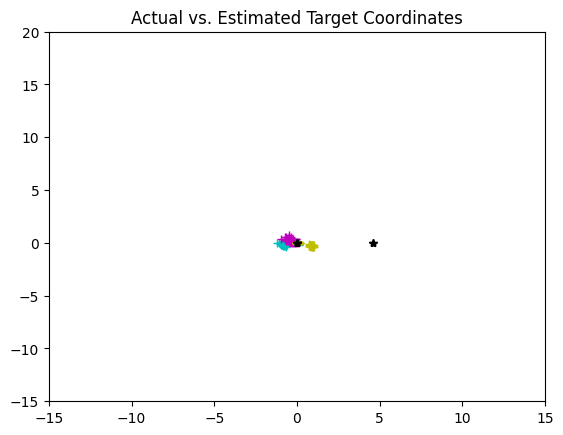

In [9]:
data = {}
data["Scenario A - RPI-BLT"] = apply_WLS_estimator(constants.SCENARIO_A_PATH + "RPI/RSS_BLT_Dataset/")
data["Scenario A - RPI-WiFi"] = apply_WLS_estimator(constants.SCENARIO_A_PATH + "RPI/RSS_WiFi_Dataset/")
data["Scenario B - RPI-BLT"] = apply_WLS_estimator(constants.SCENARIO_B_PATH + "RPI/RSS_BLT_Dataset/")
data["Scenario B - RPI-WiFi"] = apply_WLS_estimator(constants.SCENARIO_B_PATH + "RPI/RSS_WiFi_Dataset/")
data["Scenario C - RPI-BLT"] = apply_WLS_estimator(constants.SCENARIO_C_PATH + "RPI/RSS_BLT_Dataset/")
data["Scenario C - RPI-WiFi"] = apply_WLS_estimator(constants.SCENARIO_C_PATH + "RPI/RSS_WiFi_Dataset/")

# np.set_printoptions(suppress=True)
# pprint.pprint(data)

plot.title("Actual vs. Estimated Target Coordinates")
plot.ylim(-15, 20)
plot.xlim(-15, 15)

for key in data:
    if key == 'Scenario A - RPI-BLT':
        format = 'c+'
    if key == 'Scenario A - RPI-WiFi':
        format = 'c_'
    if key == 'Scenario B - RPI-BLT':
        format = 'm+'
    if key == 'Scenario B - RPI-WiFi':
        format = 'm_'
    if key == 'Scenario C - RPI-BLT':
        format = 'y+'
    if key == 'Scenario C - RPI-WiFi':
        format = 'y_'
    scenario = data[key]
    for configuration in scenario["Estimated"].values():
        target_estimation = configuration["Target Coordinates"]
        plot.plot(target_estimation[0], target_estimation[1], format, label=key)

for key in data:
    scenario = data[key]
    target_actual = scenario["Actual"]["Target Coordinates"]
    plot.plot(target_actual[0], target_actual[1], 'k*', label=key)
    # plot.text(target_estimation[0], target_estimation[1], key, fontsize='xx-small', horizontalalignment='center')

# https://stackoverflow.com/questions/20186344/importing-an-ipynb-file-from-another-ipynb-file
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
# https://stackoverflow.com/questions/28504737/how-to-plot-a-single-point-in-matplotlib
# https://www.scaler.com/topics/matplotlib/matplotlib-set-axis-range/